In [1]:
import os
import re
from tqdm import tqdm
import numpy as np
import pandas as pd
import nltk
nltk.download('punkt_tab')
import matplotlib.pyplot as plt
import torch

%matplotlib inline

[nltk_data] Downloading package punkt_tab to C:\Users\Phuong
[nltk_data]     Trang\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [ ]:
# NOTE: uncomment this to download data
# URL = 'https://www.cs.cornell.edu/people/pabo/movie-review-data/rt-polaritydata.tar.gz'
# # Download Datasets
# !wget -P 'Data/' $URL
# # Unzip
# !tar xvzf 'Data/rt-polaritydata.tar.gz' -C 'Data/'

--2024-11-22 02:13:15--  https://www.cs.cornell.edu/people/pabo/movie-review-data/rt-polaritydata.tar.gz
Resolving www.cs.cornell.edu (www.cs.cornell.edu)... 132.236.207.53
Connecting to www.cs.cornell.edu (www.cs.cornell.edu)|132.236.207.53|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 487770 (476K) [application/x-gzip]
Saving to: ‘Data/rt-polaritydata.tar.gz’

rt-polaritydata.tar 100%[===================>] 476.34K  1.07MB/s    in 0.4s    

2024-11-22 02:13:16 (1.07 MB/s) - ‘Data/rt-polaritydata.tar.gz’ saved [487770/487770]

rt-polaritydata.README.1.0.txt
rt-polaritydata/rt-polarity.neg
rt-polaritydata/rt-polarity.pos


# Download & Process another dataset

In [ ]:
# Download datasets
!rm -rf ./data
!wget https://raw.githubusercontent.com/yao8839836/text_gcn/master/data/mr/text_train.txt -P ./data/mr/
!wget https://raw.githubusercontent.com/yao8839836/text_gcn/master/data/mr/text_test.txt -P ./data/mr/
!wget https://raw.githubusercontent.com/yao8839836/text_gcn/master/data/mr/label_train.txt -P ./data/mr/
!wget https://raw.githubusercontent.com/yao8839836/text_gcn/master/data/mr/label_test.txt -P ./data/mr/
!wget https://raw.githubusercontent.com/yao8839836/text_gcn/master/data/R8/train.txt -P ./data/R8/
!wget https://raw.githubusercontent.com/yao8839836/text_gcn/master/data/R8/test.txt -P ./data/R8/

--2024-11-22 02:13:16--  https://raw.githubusercontent.com/yao8839836/text_gcn/master/data/mr/text_train.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 832706 (813K) [application/octet-stream]
Saving to: ‘./data/mr/text_train.txt’

text_train.txt      100%[===================>] 813.19K  --.-KB/s    in 0.02s   

2024-11-22 02:13:17 (41.2 MB/s) - ‘./data/mr/text_train.txt’ saved [832706/832706]

--2024-11-22 02:13:17--  https://raw.githubusercontent.com/yao8839836/text_gcn/master/data/mr/text_test.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting respo

In [ ]:
# Preprocessing into "list of texts" and "list of labels"
def load_mr(filename):
    with open(filename, 'rb') as f:
        texts = []
        for line in f:
            item = line.decode(errors='ignore').lower().strip()
            if item == '0' or item == '1':
                item = int(item)
            texts.append(item)

    return np.array(texts)

r8_dict = {
    "acq": 0,
    "crude": 1,
    "earn": 2,
    "grain": 3,
    "interest": 4,
    "money-fx": 5,
    "ship": 6,
    "trade": 7
}
def load_r8(filename):
    with open(filename, 'rb') as f:
        texts = []
        labels = []
        for line in f:
            line = line.decode(errors='ignore').split("\t")
            text, label = line[1], line[0]
            texts.append(text)
            labels.append(r8_dict[label])

    return np.array(texts), np.array(labels)

mr_train_texts = load_mr('./data/mr/text_train.txt')
mr_test_texts = load_mr('./data/mr/text_test.txt')
mr_train_labels = load_mr('./data/mr/label_train.txt')
mr_test_labels = load_mr('./data/mr/label_test.txt')
r8_train_texts, r8_train_labels = load_r8('./data/R8/train.txt')
r8_test_texts, r8_test_labels = load_r8('./data/R8/test.txt')

# Build model

In [2]:
def load_text(path):
    '''Load text data, lowercase and save to a list'''
    with open(path, 'rb') as f:
        texts = []
        for line in f:
            texts.append(line.decode(errors='ignore').lower().strip())

    return texts

# Load files
neg_text = load_text('D:\\VSC\\machine-learning-crash-course\\deep-neural-networks\\deep-learning\\data\\rt-polaritydata\\rt-polaritydata\\rt-polarity.neg')
pos_text = load_text('D:\\VSC\\machine-learning-crash-course\\deep-neural-networks\\deep-learning\\data\\rt-polaritydata\\rt-polaritydata\\rt-polarity.pos')

# Concatenate and label data
texts = np.array(neg_text + pos_text)
labels = np.array([0]*len(neg_text) + [1]*len(pos_text))

In [3]:
len(texts), len(labels)

(10662, 10662)

In [ ]:
# NOTE: uncomment this to download pretrained embedding vectors
# download fastText pretrained word vectors
# %%time
# URL = "https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip"
# FILE = "fastText"

# if os.path.isdir(FILE):
#     print("fastText exists.")
# else:
#     !wget -P $FILE $URL
#     !unzip $FILE/crawl-300d-2M.vec.zip -d $FILE

--2024-11-21 00:42:48--  https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.35.238.71, 13.35.238.84, 13.35.238.103, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.35.238.71|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1523785255 (1.4G) [application/zip]
Saving to: ‘fastText/crawl-300d-2M.vec.zip’

crawl-300d-2M.vec.z 100%[===================>]   1.42G   145MB/s    in 7.5s    

2024-11-21 00:42:56 (195 MB/s) - ‘fastText/crawl-300d-2M.vec.zip’ saved [1523785255/1523785255]

Archive:  fastText/crawl-300d-2M.vec.zip
  inflating: fastText/crawl-300d-2M.vec  
CPU times: user 438 ms, sys: 73.5 ms, total: 512 ms
Wall time: 1min 9s


In [4]:
from nltk.tokenize import word_tokenize
from collections import defaultdict

def tokenize(texts):
    """Tokenize texts, build vocabulary and find maximum sentence length.

    Args:
        texts (List[str]): List of text data

    Returns:
        tokenized_texts (List[List[str]]): List of list of tokens
        word2idx (Dict): Vocabulary built from the corpus
        max_len (int): Maximum sentence length
    """

    max_len = 0
    tokenized_texts = []
    word2idx = {}

    # Add <pad> and <unk> tokens to the vocabulary
    word2idx['<pad>'] = 0
    word2idx['<unk>'] = 1

    # Building our vocab from the corpus starting from index 2
    idx = 2
    for sent in texts:
        tokenized_sent = word_tokenize(sent)

        # Add `tokenized_sent` to `tokenized_texts`
        tokenized_texts.append(tokenized_sent)

        # Add new token to `word2idx`
        for token in tokenized_sent:
            if token not in word2idx:
                word2idx[token] = idx
                idx += 1

        # Update `max_len`
        max_len = max(max_len, len(tokenized_sent))

    return tokenized_texts, word2idx, max_len

def encode(tokenized_texts, word2idx, max_len):
    """Pad each sentence to the maximum sentence length and encode tokens to
    their index in the vocabulary.

    Returns:
        input_ids (np.array): Array of token indexes in the vocabulary with
            shape (N, max_len). It will the input of our CNN model.
    """

    input_ids = []
    for tokenized_sent in tokenized_texts:
        # Pad sentences to max_len
        tokenized_sent += ['<pad>'] * (max_len - len(tokenized_sent))

        # Encode tokens to input_ids
        input_id = [word2idx.get(token) for token in tokenized_sent]
        input_ids.append(input_id)

    return np.array(input_ids)

In [5]:
from tqdm.notebook import tqdm

def load_pretrained_vectors(word2idx, fname):
    """Load pretrained vectors and create embedding layers.

    Args:
        word2idx (Dict): Vocabulary built from the corpus
        fname (str): Path to pretrained vector file

    Returns:
        embeddings (np.array): Embedding matrix with shape (N, d) where N is
            the size of word2idx and d is embedding dimension
    """

    print("Loading pretrained vectors...")
    fin = open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())

    # Initilize random embeddings
    embeddings = np.random.uniform(-0.25, 0.25, (len(word2idx), d))
    embeddings[word2idx['<pad>']] = np.zeros((d,))

    # Load pretrained vectors
    count = 0
    for line in tqdm(fin):
        tokens = line.rstrip().split(' ')
        word = tokens[0]
        if word in word2idx:
            count += 1
            embeddings[word2idx[word]] = np.array(tokens[1:], dtype=np.float32)

    print(f"There are {count} / {len(word2idx)} pretrained vectors found.")

    return embeddings

In [6]:
# Tokenize, build vocabulary, encode tokens
print("Tokenizing...\n")
tokenized_texts, word2idx, max_len = tokenize(texts)
input_ids = encode(tokenized_texts, word2idx, max_len)

# Load pretrained vectors
embeddings = load_pretrained_vectors(word2idx, "D:\\VSC\\machine-learning-crash-course\\deep-neural-networks\\deep-learning\\data\\crawl-300d-2M.vec\\crawl-300d-2M.vec")
embeddings = torch.tensor(embeddings)

Tokenizing...

Loading pretrained vectors...


0it [00:00, ?it/s]

There are 18522 / 20280 pretrained vectors found.


In [ ]:
word2idx

{'<pad>': 0,
 '<unk>': 1,
 'simplistic': 2,
 ',': 3,
 'silly': 4,
 'and': 5,
 'tedious': 6,
 '.': 7,
 'it': 8,
 "'s": 9,
 'so': 10,
 'laddish': 11,
 'juvenile': 12,
 'only': 13,
 'teenage': 14,
 'boys': 15,
 'could': 16,
 'possibly': 17,
 'find': 18,
 'funny': 19,
 'exploitative': 20,
 'largely': 21,
 'devoid': 22,
 'of': 23,
 'the': 24,
 'depth': 25,
 'or': 26,
 'sophistication': 27,
 'that': 28,
 'would': 29,
 'make': 30,
 'watching': 31,
 'such': 32,
 'a': 33,
 'graphic': 34,
 'treatment': 35,
 'crimes': 36,
 'bearable': 37,
 '[': 38,
 'garbus': 39,
 ']': 40,
 'discards': 41,
 'potential': 42,
 'for': 43,
 'pathological': 44,
 'study': 45,
 'exhuming': 46,
 'instead': 47,
 'skewed': 48,
 'melodrama': 49,
 'circumstantial': 50,
 'situation': 51,
 'visually': 52,
 'flashy': 53,
 'but': 54,
 'narratively': 55,
 'opaque': 56,
 'emotionally': 57,
 'vapid': 58,
 'exercise': 59,
 'in': 60,
 'style': 61,
 'mystification': 62,
 'story': 63,
 'is': 64,
 'also': 65,
 'as': 66,
 'unoriginal': 6

In [7]:
from torch.utils.data import (TensorDataset, DataLoader, RandomSampler, SequentialSampler)

def data_loader(train_inputs, val_inputs, train_labels, val_labels, batch_size: int=50):
  """Convert train and validation sets to torch.Tensors and load them to
    DataLoader.
    """
  train_inputs, val_inputs, train_labels, val_labels = \
  tuple(torch.tensor(data) for data in
        [train_inputs, val_inputs, train_labels, val_labels])

  train_data = TensorDataset(train_inputs, train_labels)
  train_sampler = RandomSampler(train_data)
  train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

  # Create DataLoader for validation data
  val_data = TensorDataset(val_inputs, val_labels)
  val_sampler = SequentialSampler(val_data)
  val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

  return train_dataloader, val_dataloader

In [8]:
from sklearn.model_selection import train_test_split

# Train Test Split
train_inputs, val_inputs, train_labels, val_labels = train_test_split(
    input_ids, labels, test_size=0.1, random_state=42)

# Load data to PyTorch DataLoader
train_dataloader, val_dataloader = data_loader(train_inputs, val_inputs, train_labels, val_labels, batch_size=50)

In [ ]:
# Sample configuration:
filter_sizes = [2, 3, 4]
num_filters = [2, 2, 2]

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN_NLP(nn.Module):
    """An 1D Convulational Neural Network for Sentence Classification."""
    def __init__(self,
                 pretrained_embedding=None,
                 freeze_embedding=False,
                 vocab_size=None,
                 embed_dim=300,
                 filter_sizes=[3, 4, 5],
                 num_filters=[100, 100, 100],
                 num_classes=2,
                 dropout=0.5):
        """
        The constructor for CNN_NLP class.

        Args:
            pretrained_embedding (torch.Tensor): Pretrained embeddings with
                shape (vocab_size, embed_dim)
            freeze_embedding (bool): Set to False to fine-tune pretraiend
                vectors. Default: False
            vocab_size (int): Need to be specified when not pretrained word
                embeddings are not used.
            embed_dim (int): Dimension of word vectors. Need to be specified
                when pretrained word embeddings are not used. Default: 300
            filter_sizes (List[int]): List of filter sizes. Default: [3, 4, 5]
            num_filters (List[int]): List of number of filters, has the same
                length as `filter_sizes`. Default: [100, 100, 100]
            n_classes (int): Number of classes. Default: 2
            dropout (float): Dropout rate. Default: 0.5
        """

        super(CNN_NLP, self).__init__()
        # Embedding layer
        if pretrained_embedding is not None:
            self.vocab_size, self.embed_dim = pretrained_embedding.shape
            self.embedding = nn.Embedding.from_pretrained(pretrained_embedding,
                                                          freeze=freeze_embedding)
        else:
            self.embed_dim = embed_dim
            self.embedding = nn.Embedding(num_embeddings=vocab_size,
                                          embedding_dim=self.embed_dim,
                                          padding_idx=0,
                                          max_norm=5.0)
        # Conv Network
        self.conv1d_list = nn.ModuleList([
            nn.Conv1d(in_channels=self.embed_dim,
                      out_channels=num_filters[i],
                      kernel_size=filter_sizes[i])
            for i in range(len(filter_sizes))
        ])
        # Fully-connected layer and Dropout
        self.fc = nn.Linear(np.sum(num_filters), num_classes)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, input_ids):
        """Perform a forward pass through the network.

        Args:
            input_ids (torch.Tensor): A tensor of token ids with shape
                (batch_size, max_sent_length)

        Returns:
            logits (torch.Tensor): Output logits with shape (batch_size,
                n_classes)
        """

        # Get embeddings from `input_ids`. Output shape: (b, max_len, embed_dim)
        x_embed = self.embedding(input_ids).float()

        # Permute `x_embed` to match input shape requirement of `nn.Conv1d`.
        # Output shape: (b, embed_dim, max_len)
        x_reshaped = x_embed.permute(0, 2, 1)

        # Apply CNN and ReLU. Output shape: (b, num_filters[i], L_out)
        x_conv_list = [F.relu(conv1d(x_reshaped)) for conv1d in self.conv1d_list]

        # Max pooling. Output shape: (b, num_filters[i], 1)
        x_pool_list = [F.max_pool1d(x_conv, kernel_size=x_conv.shape[2])
            for x_conv in x_conv_list]

        # Concatenate x_pool_list to feed the fully connected layer.
        # Output shape: (b, sum(num_filters))
        x_fc = torch.cat([x_pool.squeeze(dim=2) for x_pool in x_pool_list],
                         dim=1)

        # Compute logits. Output shape: (b, n_classes)
        logits = self.fc(self.dropout(x_fc))

        return logits

In [11]:
device = 'cuda' if torch.cuda.is_available() else "cpu"
EPOCHS = 20
lr = 0.1

In [12]:
import torchmetrics
loss_fn = nn.CrossEntropyLoss() # this is also called "criterion"/"cost function" in some places

In [17]:
import torch.optim as optim

def initilize_model(pretrained_embedding=None,
                    freeze_embedding=False,
                    vocab_size=None,
                    embed_dim=300,
                    filter_sizes=[3, 4, 5],
                    num_filters=[100, 100, 100],
                    num_classes=2,
                    dropout=0.5,
                    learning_rate=0.01,
                    ):
    """Instantiate a CNN model and an optimizer."""

    assert (len(filter_sizes) == len(num_filters)), "filter_sizes and \
    num_filters need to be of the same length."

    # Instantiate CNN model
    cnn_model = CNN_NLP(pretrained_embedding=pretrained_embedding,
                        freeze_embedding=freeze_embedding,
                        vocab_size=vocab_size,
                        embed_dim=embed_dim,
                        filter_sizes=filter_sizes,
                        num_filters=num_filters,
                        num_classes=2,
                        dropout=0.5)

    # Send model to `device` (GPU/CPU)
    cnn_model.to(device)

    # Instantiate Adadelta optimizer
    optimizer = optim.SGD(cnn_model.parameters(), lr=lr)

    return cnn_model, optimizer

In [26]:
import random
import time

# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility."""

    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, optimizer, train_dataloader, val_dataloader=None, epochs=10):
    """Train the CNN model."""

    # Tracking best validation accuracy
    best_accuracy = 0
    train_cost = []
    train_acc = []
    ls_val_acc = []
    ls_val_loss = []

    # Start training loop
    print("Start training...\n")
    print(f"{'Epoch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Train Acc':^9} | {'Elapsed':^9}")
    print("-"*60)

    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================

        # Tracking time and loss
        t0_epoch = time.time()
        total_loss = 0
        total_acc = 0
        # Put the model into the training mode
        model.train()

        for step, batch in enumerate(train_dataloader):
            # Load batch to GPU
            b_input_ids, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            total_loss += loss.item()

            # Get the predictions
            preds = torch.argmax(logits, dim=1).flatten()
            # Calculate the accuracy rate
            train_accuracy = (preds == b_labels).cpu().numpy().mean()
            total_acc += train_accuracy

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Update parameters
            optimizer.step()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)
        avg_train_acc = total_acc / len(train_dataloader)
        train_cost.append(avg_train_loss)
        train_acc.append(avg_train_acc)
        

        # =======================================
        #               Evaluation
        # =======================================
        if val_dataloader is not None:
            # After the completion of each training epoch, measure the model's
            # performance on our validation set.
            val_loss, val_acc = evaluate(model, val_dataloader)
            ls_val_loss.append(val_loss)
            ls_val_acc.append(val_acc)

            # Track the best accuracy
            if val_acc > best_accuracy:
                best_accuracy = val_acc

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            print(f"{epoch_i + 1:^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_acc:^9.2f} | {avg_train_acc:^9.2f}| {time_elapsed:^9.2f}")

    print("\n")
    print(f"Training complete! Best accuracy: {best_accuracy:.2f}")
    return train_cost, train_acc, ls_val_loss, ls_val_acc

def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's
    performance on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled
    # during the test time.
    model.eval()
    
    # Tracking variables
    val_acc = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss)

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean()
        val_acc.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_acc = np.mean(val_acc)

    return val_loss, val_acc

In [27]:
# CNN-rand: Word vectors are randomly initialized.
set_seed(42)
cnn_rand, optimizer = initilize_model(vocab_size=len(word2idx),
                                      embed_dim=300,
                                      learning_rate=0.25,
                                      dropout=0.5)
train_cost, train_acc, val_cost, val_acc = train(cnn_rand, optimizer, train_dataloader, val_dataloader, epochs=20)

Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  | Train Acc |  Elapsed 
------------------------------------------------------------
   1    |   0.701529   |  0.686325  |   0.53    |   0.54   |   7.43   
   2    |   0.653264   |  0.631503  |   0.63    |   0.61   |   7.04   
   3    |   0.591669   |  0.623042  |   0.65    |   0.68   |   7.03   
   4    |   0.512310   |  0.569203  |   0.69    |   0.75   |   7.21   
   5    |   0.430722   |  0.561545  |   0.69    |   0.81   |   7.41   
   6    |   0.353969   |  0.557870  |   0.71    |   0.85   |   7.63   
   7    |   0.277802   |  0.576783  |   0.70    |   0.90   |   7.63   
   8    |   0.208517   |  0.575838  |   0.71    |   0.93   |   7.60   
   9    |   0.172146   |  0.586631  |   0.71    |   0.94   |   7.34   
  10    |   0.140995   |  0.595055  |   0.72    |   0.96   |   7.29   
  11    |   0.117330   |  0.620292  |   0.71    |   0.96   |   7.11   
  12    |   0.096156   |  0.613391  |   0.72    |   0.97   |   9.39

In [28]:
def plot_metrics(train_loss, train_acc, val_loss, val_acc, epochs):
    """
    Plot training and testing loss and accuracy.

    Args:
        train_loss (list): List of training loss values for each epoch (tensors or floats).
        train_acc (list): List of training accuracy values for each epoch (tensors or floats).
        test_loss (list): List of testing loss values for each epoch (tensors or floats).
        test_acc (list): List of testing accuracy values for each epoch (tensors or floats).
        epochs (int): Number of epochs.
    """
    # Convert all tensors to CPU and NumPy if necessary
    train_loss = [tl.cpu().item() if isinstance(tl, torch.Tensor) else tl for tl in train_loss]
    train_acc = [ta.cpu().item() if isinstance(ta, torch.Tensor) else ta for ta in train_acc]
    val_loss = [tl.cpu().item() if isinstance(tl, torch.Tensor) else tl for tl in val_loss]
    val_acc = [ta.cpu().item() if isinstance(ta, torch.Tensor) else ta for ta in val_acc]
    
    epochs_range = range(epochs)

    plt.figure(figsize=(14, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_loss, label="Train Loss")
    plt.plot(epochs_range, val_loss, label="Val Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Testing Loss")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_acc, label="Train Accuracy")
    plt.plot(epochs_range, val_acc, label="Val Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training and Val Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

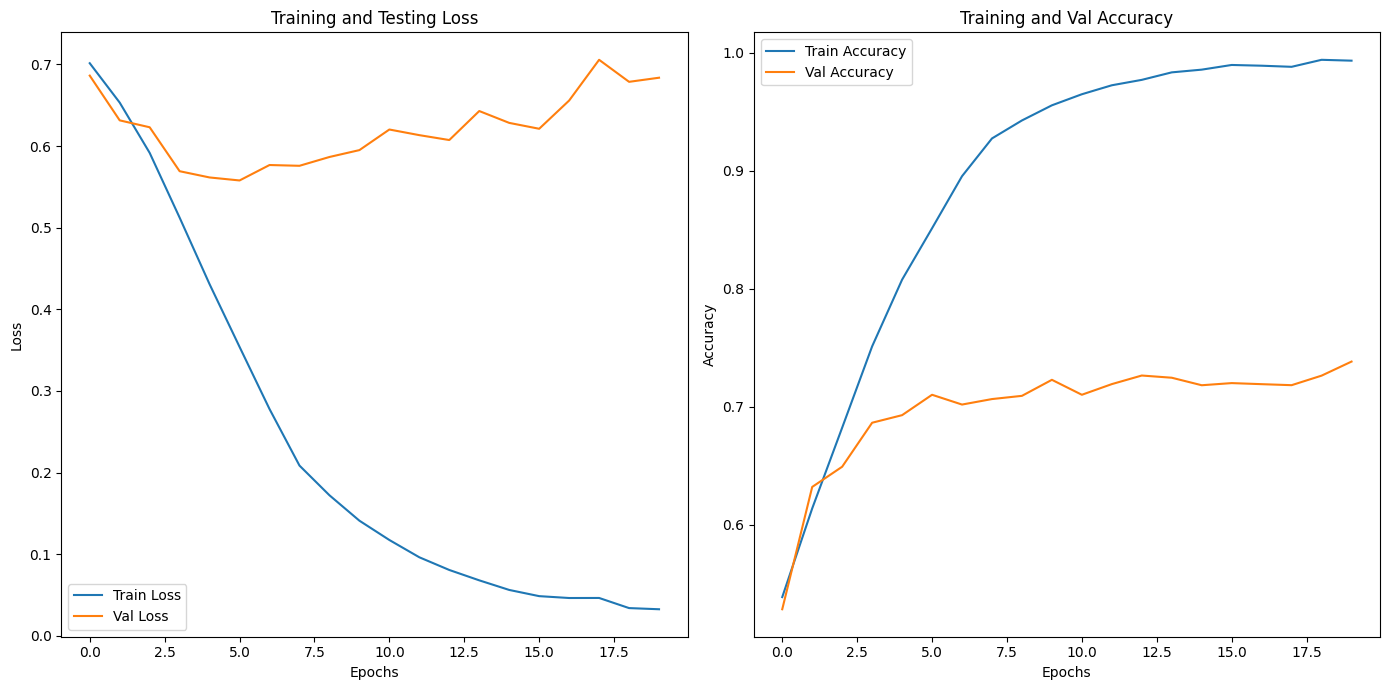

In [29]:
plot_metrics(train_cost, train_acc, val_cost, val_acc, EPOCHS)

In [30]:
# CNN-non-static: fastText pretrained word vectors are fine-tuned during training.
set_seed(42)
cnn_non_static, optimizer = initilize_model(pretrained_embedding=embeddings,
                                            freeze_embedding=False,
                                            learning_rate=0.25,
                                            dropout=0.5)
train_cost, train_acc, val_cost, val_acc = train(cnn_non_static, optimizer, train_dataloader, val_dataloader, epochs=20)

Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  | Train Acc |  Elapsed 
------------------------------------------------------------
   1    |   0.623819   |  0.497372  |   0.76    |   0.64   |   7.63   
   2    |   0.476023   |  0.445997  |   0.79    |   0.78   |   7.46   
   3    |   0.415667   |  0.418826  |   0.81    |   0.81   |   7.40   
   4    |   0.357415   |  0.415015  |   0.81    |   0.85   |   7.37   
   5    |   0.311268   |  0.412648  |   0.81    |   0.87   |   7.06   
   6    |   0.261066   |  0.407591  |   0.82    |   0.90   |   7.10   
   7    |   0.235581   |  0.476490  |   0.78    |   0.91   |   7.09   
   8    |   0.193865   |  0.412735  |   0.82    |   0.93   |   7.04   
   9    |   0.157819   |  0.428823  |   0.82    |   0.95   |   6.99   
  10    |   0.112484   |  0.443894  |   0.82    |   0.97   |   6.99   
  11    |   0.113039   |  0.461441  |   0.81    |   0.97   |   6.94   
  12    |   0.079980   |  0.509484  |   0.80    |   0.98   |   6.99

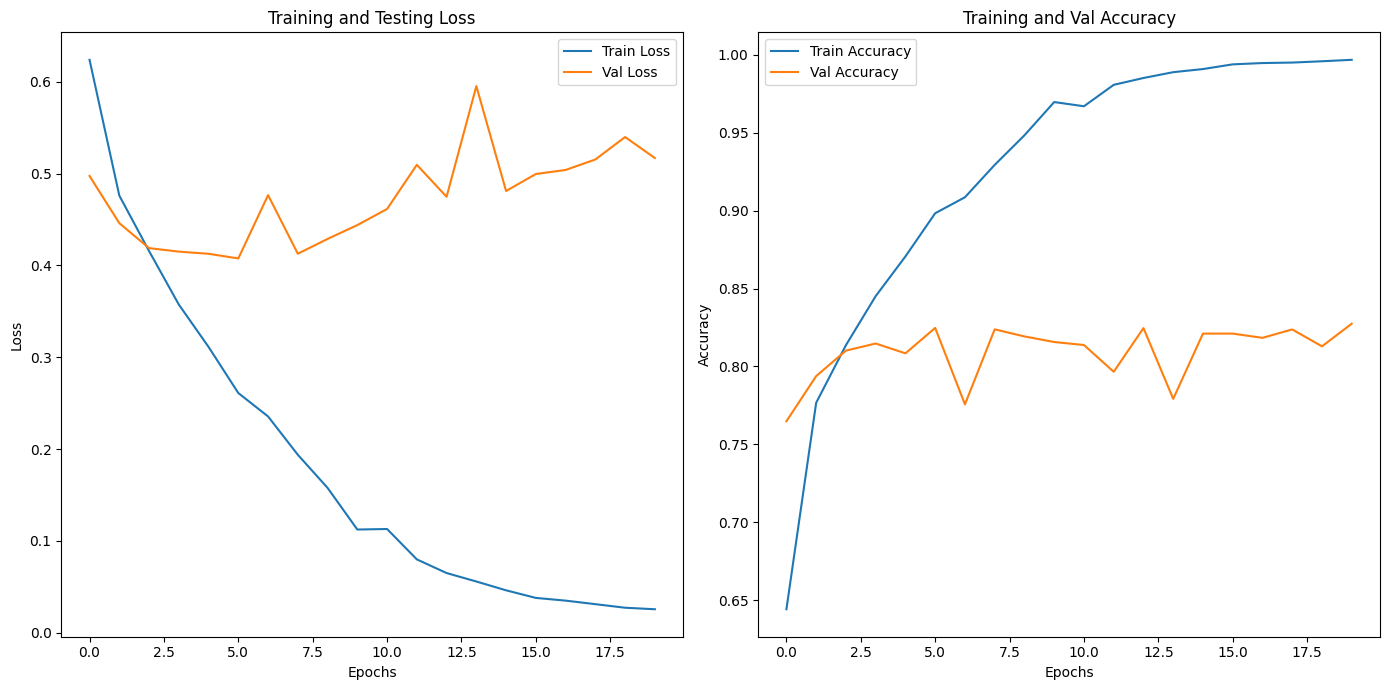

In [31]:
plot_metrics(train_cost, train_acc, val_cost, val_acc, EPOCHS)

In [32]:
def predict(text, model=cnn_non_static.to("cpu"), max_len=62):
    """Predict probability that a review is positive."""

    # Tokenize, pad and encode text
    tokens = word_tokenize(text.lower())
    padded_tokens = tokens + ['<pad>'] * (max_len - len(tokens))
    input_id = [word2idx.get(token, word2idx['<unk>']) for token in padded_tokens]

    # Convert to PyTorch tensors
    input_id = torch.tensor(input_id).unsqueeze(dim=0)

    # Compute logits
    logits = model.forward(input_id)

    #  Compute probability
    probs = F.softmax(logits, dim=1).squeeze(dim=0)

    print(f"This review is {probs[1] * 100:.2f}% positive.")

In [ ]:
predict("All of friends slept while watching this movie. But I really enjoyed it.")
predict("I have waited so long for this movie. I am now so satisfied and happy.")
predict("This movie is long and boring.")
predict("I don't like the ending.")

This review is 48.91% positive.
This review is 56.20% positive.
This review is 0.04% positive.
This review is 14.49% positive.
